In [5]:
import pyart
import fsspec
import xarray as xr
import xradar as xd
import boto3
import botocore
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from botocore.client import Config
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
def create_query(date, radar_site):
    """
    Creates a query for listing IDEAM radar files stored in AWS bucket
    :param date: date to be queried. e.g datetime(2021, 10, 3, 12). Datetime python object
    :param radar_site: radar site e.g. Guaviare
    :return: string with a
    """
    prefix = f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}'
    return prefix

In [3]:
radars = ['Guaviare', 'Munchique', 'Tablazo', 'Barrancabermeja', 'Carimagua', "Corozal", "Bogota", 'santa_elena']

Guaviare


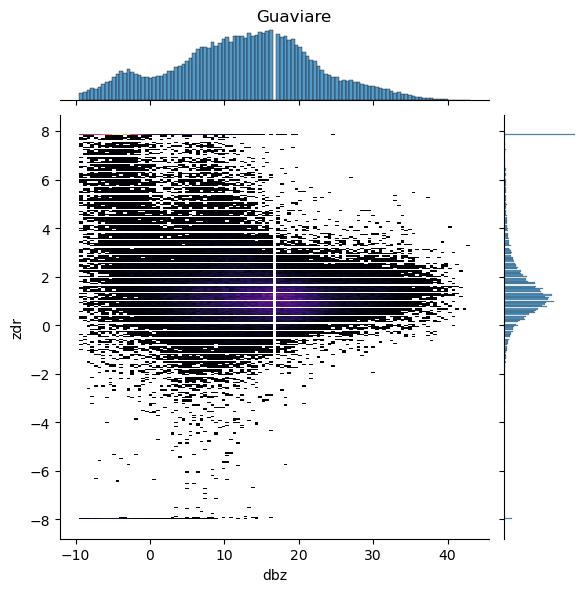

Munchique
data not available from Munchique
Tablazo


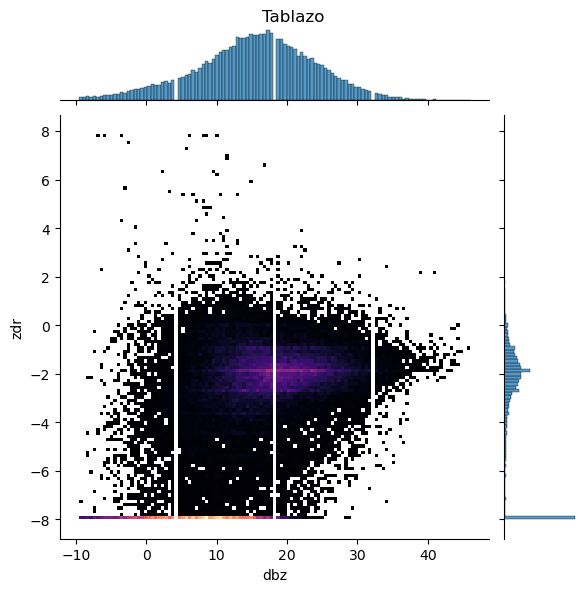

Barrancabermeja


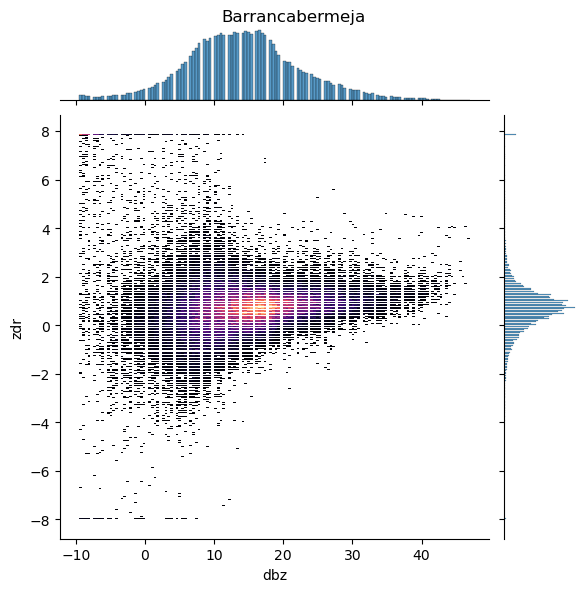

Carimagua


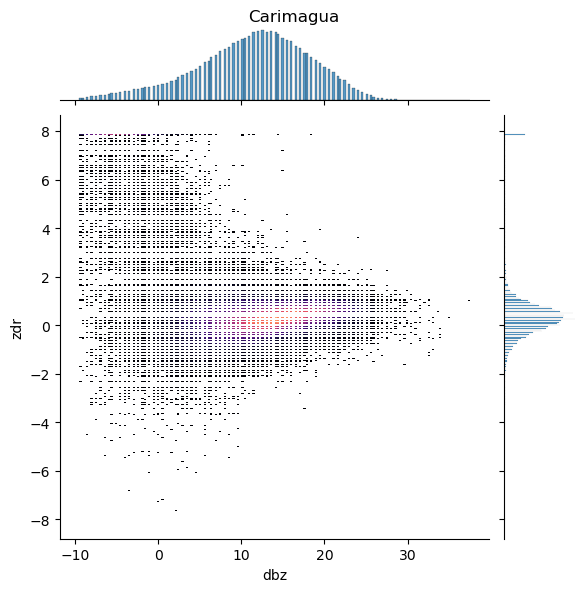

Corozal


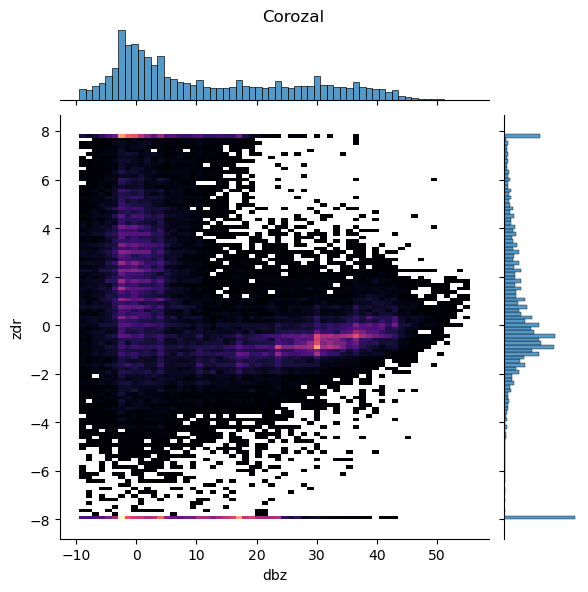

Bogota
data not available from Bogota
santa_elena
data not available from santa_elena


In [24]:
str_bucket = 's3://s3-radaresideam/'

s3 = boto3.resource('s3',
                    config=Config(signature_version=botocore.UNSIGNED, 
                                  user_agent_extra='Resource'))

bucket = s3.Bucket('s3-radaresideam')

for radar in radars:
    print(radar)
    query = create_query(date=datetime(2022, 11, 29), radar_site=radar)
    radar_files = [f'{str_bucket}{i.key}' for i in bucket.objects.filter(Prefix=f"{query}")]
    if radar_files:
        for i in radar_files[1:20]:
            file = fsspec.open_local(f'simplecache::{radar_files[0]}', s3={'anon': True}, filecache={'cache_storage': '.'})
            ds = xr.open_dataset(file, engine="iris", group="sweep_0")
            try:
                dbz = ds.DBZH.where(ds.RHOHV > 0.95).values.flatten()
                zdr = ds.ZDR.where(ds.RHOHV > 0.95).values.flatten()
            except AttributeError:
                dbz = ds.DBZH.values.flatten()
                zdr = ds.ZDR.values.flatten()
            try:
                ds = xr.open_dataset(file, group="sweep_0",  engine="iris")
                try:
                    dbz = np.append(dbz, ds.DBZH.where(ds.RHOHV > 0.95).values.flatten())
                    zdr = np.append(zdr, ds.ZDR.where(ds.RHOHV > 0.95).values.flatten())
                except AttributeError:
                    dbz = np.append(dbz, ds.DBZH.values.flatten())
                    zdr = np.append(zdr, ds.ZDR.values.flatten())
                    
            except KeyError:
                try:
                    ds = xr.open_dataset(file, group="sweep_1",  engine="iris")
                    try:
                        dbz = np.append(dbz, ds.DBZH.where(ds.RHOHV > 0.95).values.flatten())
                        zdr =  np.append(zdr, ds.ZDR.where(ds.RHOHV > 0.95).values.flatten())
                    except AttributeError:
                        dbz = np.append(dbz, ds.DBZH.values.flatten())
                        zdr =  np.append(zdr, ds.ZDR.values.flatten())
                except KeyError:
                    continue
        df = pd.DataFrame(data=np.column_stack((dbz, zdr)), columns=['dbz', 'zdr'])
        df = df[df['dbz'] > -10]

        p = sns.jointplot(data=df, x="dbz", y="zdr", kind="hist", cmap='magma')
        p.fig.suptitle(f"{radar}")
        p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
        plt.show()
        del radar_files, ds, dbz, zdr, df
    else: 
        print(f'data not available from {radar}')